In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices() 

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14304762421554178646, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 11332668621
 locality {
   bus_id: 2
 }
 incarnation: 13644185676261765379
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:84:00.0"]

In [2]:
import h5py
import numpy as np
import PIL

from keras import backend as K
from keras.preprocessing import image

from keras.models import Sequential, Model
from keras.layers import Input, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications.vgg16 import VGG16

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [10]:
import os
import numpy as np
from glob import glob
import pandas as pd

CUR_DIR = os.getcwd()
DATA_DIR = os.path.join('/scratch', 'yns207', 'data_invasive')
W_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
print(CUR_DIR, DATA_DIR)

path = DATA_DIR
test_path = os.path.join(path, 'test')
models_path = os.path.join(path, 'results')
train_path = os.path.join(path, 'train')
valid_path = os.path.join(path, 'valid')

/home/yns207/nbs/machine_learning/invasive /scratch/yns207/data_invasive


In [34]:
inputs = Input(shape=(128,128,3))
x = Convolution2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3))(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Convolution2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Convolution2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Convolution2D(128, (3,3), activation='relu')(x)
x = Flatten()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.65)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.55)(x)
x = Dense(1, activation='sigmoid')(x)
sgd = SGD(lr = 0.001, decay=1e-6, momentum=0.8, nesterov=True)
model = Model(inputs=inputs, outputs=x)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [35]:
batch_size = 64

img_width = 128
img_height = 128

t_gen = image.ImageDataGenerator(rescale=1., 
    featurewise_center=True,
    rotation_range=10,
    width_shift_range=.1,
    height_shift_range=.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="reflect")
va_gen = image.ImageDataGenerator(rescale=1., featurewise_center=True)
te_gen = image.ImageDataGenerator(rescale=1., featurewise_center=True)

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
model_checkpoint = ModelCheckpoint('/scratch/yns207/data_invasive/model_jun20.model', monitor='val_loss')

tr_batches = t_gen.flow_from_directory(
        train_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="binary",
        shuffle=True)

va_batches = va_gen.flow_from_directory(
        valid_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="binary",
        shuffle=False)

te_batches = te_gen.flow_from_directory(
        test_path,
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode="binary",
        shuffle=False)

hist = model.fit_generator(tr_batches,
                    steps_per_epoch=(tr_batches.n//batch_size)+1,
                    validation_data=va_batches,
                    validation_steps=(va_batches.n//batch_size)+1,
                    epochs=100,
                    callbacks=[early_stopping, model_checkpoint])

Found 1836 images belonging to 2 classes.
Found 459 images belonging to 2 classes.
Found 1531 images belonging to 1 classes.
Epoch 1/100


/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/keras/preprocessing/image.py:500: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


29/29 [==============================] - 61s - loss: 5.9817 - acc: 0.6208 - val_loss: 5.4531 - val_acc: 0.6580
Epoch 2/100
29/29 [==============================] - 48s - loss: 5.9818 - acc: 0.6248 - val_loss: 5.4531 - val_acc: 0.6580
Epoch 3/100
29/29 [==============================] - 48s - loss: 5.9856 - acc: 0.6245 - val_loss: 5.4531 - val_acc: 0.6580
Epoch 4/100
29/29 [==============================] - 48s - loss: 5.9630 - acc: 0.6260 - val_loss: 5.4531 - val_acc: 0.6580
Epoch 5/100
29/29 [==============================] - 49s - loss: 5.9894 - acc: 0.6243 - val_loss: 5.4531 - val_acc: 0.6580
Epoch 00004: early stopping


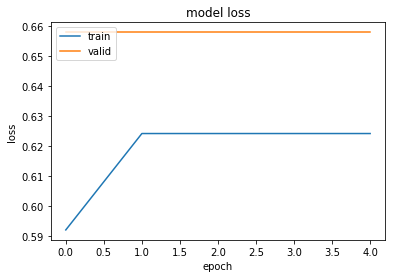

In [31]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()